# Neutrino Cross Sections

Plot the cross sections for the key in-ice interactions for ~10 MeV neutrinos in IceCube.

In [2]:
%matplotlib inline

from ussr import interactions
from ussr.neutrino import Flavor, neutrinos, antineutrinos

import astropy.units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import cycle

mpl.rc('font', size=16)

## Neutrino Interactions

There are several important neutrino interactions to consider:

1. Inverse beta decay: $\bar{\nu}_e+p \rightarrow e^{+} + n$.
2. Elastic neutrino scattering: $\nu_e + e^{-} \rightarrow \nu_e + e^{-}$ (plus antineutrino, plus $\mu$ and $\tau$).
3. Oxygen-16 charged-current interaction: $\nu_e + ^{16}\mathrm{O}\rightarrow e^{-} + \mathrm{X}$ (plus antineutrino).
4. Oxygen-16 neutral-current interaction: $\nu_\mathrm{all} + ^{16}\mathrm{O} \rightarrow \nu_\mathrm{all} + \mathrm{X}$.
5. Oxygen-18 interactions: $\nu_e + ^{17/18}\mathrm{O} / ^{2}_{1}\mathrm{H} \rightarrow e^{-} + \mathrm{X}$.

For details, see [R. Abbasi et al., A&A 535:A109, 2011](http://dx.doi.org/10.1051/0004-6361/201117810).

In [3]:
sn_interactions = [interactions.InvBetaTab(),
                   interactions.ElectronScatter(),
                   interactions.Oxygen16CC(),
                   interactions.Oxygen16NC(),
                   interactions.Oxygen18()]

lines = ["-", "--", "-.", ":"]
flavors = [Flavor.nu_e, Flavor.nu_mu, Flavor.nu_e_bar, Flavor.nu_mu_bar]

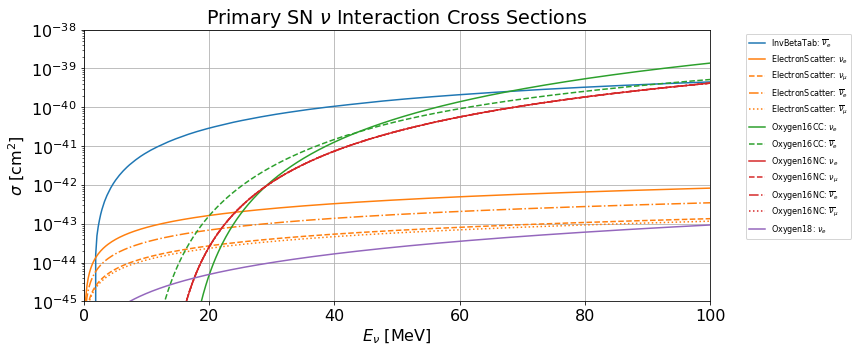

In [4]:
e_nu = np.linspace(0.1, 100., 501) * u.MeV

fig, ax = plt.subplots(1,1, figsize=(12,5))

for interaction in sn_interactions:
    color = None
    line = cycle(lines)
    for flavor in flavors:
        xs = interaction.cross_section(flavor, e_nu)
        if xs.value.any():
            label='{}: {}'.format(interaction.__class__.__name__, flavor)
            if color is None:
                p = ax.plot(e_nu, xs, next(line), label=label)
                color = p[0].get_color()
            else:
                ax.plot(e_nu, xs, next(line), label=label, color=color)

ax.grid()
ax.set(xlim=[0,100],
       xlabel=r'$E_\nu$ [MeV]',
       ylim=[1e-45, 1e-38],
       ylabel=r'$\sigma$ [cm$^2$]',
       yscale='log',
       title=r'Primary SN $\nu$ Interaction Cross Sections')

ax.legend(fontsize=8, bbox_to_anchor=(1.05,1))

fig.subplots_adjust(left=0.075, right=0.8)